### Importing of Packages


In [2]:
!pip install scikit-optimize
!pip install tensorflow
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install -U nltk
!pip install contractions
!pip install wordcloud
!pip install -q -U keras-tuner

In [3]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import numpy as np
import math
import pandas as pd
import re
import os
import string
import contractions
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
import bz2
import keras 
import string
import nltk
import keras_tuner as kt

from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, TimeDistributed, Bidirectional, Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.utils.np_utils import to_categorical
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer # decided that Lemmatizer is better
from nltk.stem import WordNetLemmatizer 


from wordcloud import WordCloud,STOPWORDS



from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.regexp import RegexpStemmer

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
#
import skopt
from skopt import BayesSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hungy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hungy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hungy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hungy\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Importing of Train Dataset

This dataset is the Amazon Reviews dataset https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews, which consists of 1,800,000 and 200,000 testing samples for each class of positive/negative

In [4]:
train_label = []
train_review = []

with open('train.ft.txt', encoding = 'utf-8') as f:
  train_lines = f.readlines()
for line in train_lines:
  train_label.append(int(line[9]) - 1) # Label 0 if negative, 1 if positive
  train_review.append(line[11:])
  #if len(train_label) == 1500000:
  #  break

d_train = {'Reviews':train_review,'Label':train_label}
df_train = pd.DataFrame(d_train)

df_train

,Reviews,Label
0,Stuning even for the non-gamer: This sound tra...,1
1,The best soundtrack ever to anything.: I'm rea...,1
2,Amazing!: This soundtrack is my favorite music...,1
3,Excellent Soundtrack: I truly like this soundt...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",1
...,...,...
3599995,Don't do it!!: The high chair looks great when...,0
3599996,"Looks nice, low functionality: I have used thi...",0
3599997,"compact, but hard to clean: We have a small ho...",0
3599998,what is it saying?: not sure what this book is...,0


#### Importing of Test Dataset

In [5]:
test_label = []
test_review = []

with open('test.ft.txt', encoding = 'utf-8') as f:
  test_lines = f.readlines()
for line in test_lines:
  test_label.append(int(line[9]) - 1) # Label 0 if negative, 1 if positive
  test_review.append(line[11:])
  if len(test_label) == 500000:
    break

d_test = {'Reviews':test_review,'Label':test_label}
df_test = pd.DataFrame(d_test)

df_test

,Reviews,Label
0,Great CD: My lovely Pat has one of the GREAT v...,1
1,One of the best game music soundtracks - for a...,1
2,Batteries died within a year ...: I bought thi...,0
3,"works fine, but Maha Energy is better: Check o...",1
4,Great for the non-audiophile: Reviewed quite a...,1
...,...,...
399995,Unbelievable- In a Bad Way: We bought this Tho...,0
399996,"Almost Great, Until it Broke...: My son reciev...",0
399997,Disappointed !!!: I bought this toy for my son...,0
399998,Classic Jessica Mitford: This is a compilation...,1


In [12]:

                  
def clean_text(text):
    text=text.apply(lambda x: re.sub('https?://\S+|www\.\S+|\S+\.com', '',x)) # Remove URLs
    text=text.apply(lambda x: re.sub(r'@\S*', '', x)) # Remove hashtags and tags
    text=text.apply(lambda x: x.lower()) #all words to lowercase
    text=text.apply(lambda x: contractions.fix(x))# Spell out contractions
    text=text.apply(lambda x: re.sub(r"[_\,\>\(\-:\)\\\/\!\.\^\!\:\];='#]",'',x)) #Remove punctuation
    text=text.apply(lambda x: re.sub(r'\w*\d\w*', '',x)) #Remove numbers
    text=text.apply(lambda x: re.sub('[^a-zA-z0-9\s]', '' , x)) # Remove special characters
    return text


def clean_text_LSTM(text):
    text=text.apply(lambda x: re.sub('https?://\S+|www\.\S+|\S+\.com', '',x)) # Remove URLs
    text=text.apply(lambda x: re.sub(r'@\S*', '', x)) # Remove hashtags and tags
    text=text.apply(lambda x: x.lower()) #all words to lowercase
    text=text.apply(lambda x: re.sub(r'\w*\d\w*', '',x)) #Remove numbers
    text=text.apply(lambda x: re.sub('[^a-zA-Z0-9\s\.\?\!\,\']+', '' , x)) # Remove special characters, 
    #except certain punctuation
    return text

In [13]:
df_train['text_lstm']= clean_text_LSTM(df_train['Reviews'])
print("1/4 done")
df_train['text']= clean_text(df_train['Reviews'])
print("2/4 done")
df_test['text_lstm']= clean_text_LSTM(df_test['Reviews'])
print("3/4 done")
df_test['text']= clean_text(df_test['Reviews'])
print("4/4 done")

1/4 done
2/4 done
3/4 done
4/4 done


In [14]:
print("Sample of unclean text: \n", df_train['Reviews'][0])
print("Sample of cleaned text: \n", df_train['text'][0])
print("Sample of partially cleaned text: \n", df_train['text_lstm'][0])

Sample of unclean text: 
 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^

Sample of cleaned text: 
 stuning even for the nongamer this sound track was beautiful it paints the senery in your mind so well i would recomend it even to people who hate vid game music i have played the game chrono cross but out of all of the games i have ever played it has the best music it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras it would impress anyone who cares to listen 

Sample of partially cleaned text: 
 stuning even for the nongamer this sound track was beautiful! it pa

## Model Builiding & Exploration
First, the text is lemmatized (but not stemmed), as this neural network is expected to be powerful.

In [17]:
lemmatizer = WordNetLemmatizer()
def lemmatize_process(words, lemmatizer):
    words = re.findall(r"[\w']+|[.,!?;]", words)
    words = [lemmatizer.lemmatize(w) for w in words]
    return words

df_train['text_lstm'] = df_train['text_lstm'].map(lambda x: lemmatize_process(x, lemmatizer))
print("1/3 done")
df_test['text_lstm'] = df_test['text_lstm'].map(lambda x: lemmatize_process(x, lemmatizer))
print("2/3 done")
df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)
print("3/3 done")

1/3 done
2/3 done
3/3 done


In [18]:

df_train

,Reviews,Label,text_lstm,text
1655343,Buisness process improvment work book: Provide...,1,"[buisness, process, improvment, work, book, pr...",buisness process improvment work book provide ...
1920695,Excellent: Own two labs that can challenge any...,1,"[excellent, own, two, lab, that, can, challeng...",excellent own two labs that can challenge any ...
3566390,i don't like it: ita was bro...!! i don't like...,0,"[i, don't, like, it, ita, wa, bro, ., ., ., !,...",i do not like it ita was bro i do not like it ...
2981457,It's Just Not My Taste: I thought the cd was g...,0,"[it's, just, not, my, taste, i, thought, the, ...",it is just not my taste i thought the cd was g...
133640,The Marriage of Heaven & Hell. (A Memorable Fa...,1,"[the, marriage, of, heaven, hell, ., a, memora...",the marriage of heaven hell a memorable fancy...
...,...,...,...,...
991511,Disappointment: The never-can-tell Pigface str...,0,"[disappointment, the, nevercantell, pigface, s...",disappointment the nevercantell pigface stretc...
475827,Capoeira: A Dangerous Subject in the Hands of ...,0,"[capoeira, a, dangerous, subject, in, the, han...",capoeira a dangerous subject in the hands of t...
1297650,"don't like the setup: Just my opinion, but I h...",0,"[don't, like, the, setup, just, my, opinion, ,...",do not like the setup just my opinion but i ha...
2303760,Still going strong: Hed Kandi is going through...,1,"[still, going, strong, hed, kandi, is, going, ...",still going strong he would kandi is going thr...


In [19]:
df_test

,Reviews,Label,text_lstm,text
151363,The Passion Test: I found the book disappointi...,0,"[the, passion, test, i, found, the, book, disa...",the passion test i found the book disappointin...
330283,So Disappointed!: I had heard the buzz about t...,0,"[so, disappointed, !, i, had, heard, the, buzz...",so disappointed i had heard the buzz about the...
14700,One of the most disturbing movies I have ever ...,0,"[one, of, the, most, disturbing, movie, i, hav...",one of the most disturbing movies i have ever ...
125472,"A Horrid Movie: First, why would Amazon allow ...",0,"[a, horrid, movie, first, ,, why, would, amazo...",a horrid movie first why would amazon allow y...
141587,Poor quality: I was so excited to purchase two...,0,"[poor, quality, i, wa, so, excited, to, purcha...",poor quality i was so excited to purchase two ...
...,...,...,...,...
362594,prefect for newborns: My daughter is 6 weeks o...,1,"[prefect, for, newborn, my, daughter, is, week...",prefect for newborns my daughter is weeks old...
370345,An all-time favorite!: We love this book! The ...,1,"[an, alltime, favorite, !, we, love, this, boo...",an alltime favorite we love this book the illu...
8628,There was no Augustus Pelltier!: Creating hist...,0,"[there, wa, no, augustus, pelltier, !, creatin...",there was no augustus pelltier creating histor...
94911,"Good Quality, Good Price: Up front, only reaso...",1,"[good, quality, ,, good, price, up, front, ,, ...",good quality good price up front only reason i...


In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['text_lstm'])
vocab = len(tokenizer.word_index) + 1 
print(f"vocabulary: {vocab}")
vocab = min(50000, vocab)
print(f"Chosen vocabulary size: {vocab}")

train_sequences = tokenizer.texts_to_sequences(df_train['text_lstm'])
data_train = pad_sequences(train_sequences, maxlen=average_input_size, padding='post', truncating='post')
print("1/2 done")
test_sequences = tokenizer.texts_to_sequences(df_test['text_lstm'])
data_test =  pad_sequences(test_sequences, maxlen=average_input_size, padding='post', truncating='post')
print("2/2 done")

vocabulary: 1403534
Chosen vocabulary size: 50000
1/2 done
2/2 done


The vocabulary size is limited to a subset of 50000 to get rid of noise.

In [21]:
X_train, X_test, y_train, y_test = data_train, data_test, df_train['Label'], df_test['Label']

In [22]:
def build_model(hp):
    
    dims = hp.Int('dims', min_value=64, max_value=120, step=16)
    kernel_size = hp.Int('kernel_size', min_value=3, max_value=6, step=1)
    filters = hp.Int('filters', min_value=16, max_value=128, step=16)
    pool_size = hp.Int('pool_size', min_value=2, max_value=8, step=2)
    learn_rate = hp.Choice('learn_rate', values=[1e-5, 1e-6, 1e-7])
    
    model = Sequential(name="LSTM_Sentiment_Classifier")
    model.add(Embedding(vocab, dims, input_length=average_input_size))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
    model.add(MaxPooling1D(pool_size=pool_size, strides=1))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.2))
    model.add(Dense(8,activation='relu'))
    model.add(Dense(1,activation='sigmoid')) 
    
    model.compile(loss='binary_crossentropy', optimizer= keras.optimizers.Adam(learning_rate=learn_rate), metrics=['accuracy'])
    
    return model

Kerastuner is used to select the best hyperparameters for the model. Multiple model weights are saved locally in json format so that any progress is not lost, and such that the best one can be chosen.

In [23]:
tuner = kt.Hyperband(build_model, objective='val_accuracy',max_epochs=16,factor=3,directory='kt',project_name='CNN-BiLSTM-Classifier', overwrite=False)

INFO:tensorflow:Reloading Tuner from kt\CNN-BiLSTM-Classifier\tuner0.json


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])


Trial 29 Complete [15h 02m 11s]
val_accuracy: 0.9430485963821411

Best val_accuracy So Far: 0.943963885307312
Total elapsed time: 5d 21h 20m 07s

Search: Running Trial #30

Value             |Best Value So Far |Hyperparameter
112               |112               |dims
6                 |3                 |kernel_size
80                |128               |filters
8                 |8                 |pool_size
1e-05             |1e-05             |learn_rate
16                |16                |tuner/epochs
0                 |6                 |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/16
90000/90000 [==============================] - 3237s 36ms/step - loss: 0.3387 - accuracy: 0.8481 - val_loss: 0.2415 - val_accuracy: 0.9027
Epoch 2/16
16777/90000 [====>.........................] - ETA: 38:32 - loss: 0.2441 - accuracy: 0.9019

In [24]:
best_hps=tuner.get_best_hyperparameters(num_trials=10)[0]
print("Best hyperparameters:")
print(f"{best_hps.values}")
print("\n\n")

tuner.results_summary()

Best hyperparameters:
{'dims': 112, 'kernel_size': 3, 'filters': 128, 'pool_size': 8, 'learn_rate': 1e-05, 'tuner/epochs': 16, 'tuner/initial_epoch': 6, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}



Results summary
Results in kt\CNN-BiLSTM-Classifier
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0016 summary
Hyperparameters:
dims: 112
kernel_size: 3
filters: 128
pool_size: 8
learn_rate: 1e-05
tuner/epochs: 16
tuner/initial_epoch: 6
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.943963885307312

Trial 0024 summary
Hyperparameters:
dims: 96
kernel_size: 5
filters: 112
pool_size: 4
learn_rate: 1e-05
tuner/epochs: 16
tuner/initial_epoch: 6
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.9436208605766296

Trial 0028 summary
Hyperparameters:
dims: 96
kernel_size: 6
filters: 128
pool_size: 6
learn_rate: 1e-05
tuner/epochs: 16
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9430485963821411

Trial

In [25]:
model = tuner.hypermodel.build(best_hps)
print(model.summary())

Model: "LSTM_Sentiment_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 79, 112)           5600000   
                                                                 
 dropout (Dropout)           (None, 79, 112)           0         
                                                                 
 conv1d (Conv1D)             (None, 77, 128)           43136     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 70, 128)          0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 70, 256)          263168    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 70, 2

After the model is built with the ideal weights, the model is finally trained on an 8GB VRAM GPU. The training process took about a week.

Epoch 1/16
90000/90000 [==============================] - 3062s 34ms/step - loss: 0.3366 - accuracy: 0.8500 - val_loss: 0.2463 - val_accuracy: 0.9009
Epoch 2/16
90000/90000 [==============================] - 3098s 34ms/step - loss: 0.2240 - accuracy: 0.9104 - val_loss: 0.1992 - val_accuracy: 0.9213
Epoch 3/16
90000/90000 [==============================] - 3071s 34ms/step - loss: 0.1947 - accuracy: 0.9236 - val_loss: 0.1944 - val_accuracy: 0.9237
Epoch 4/16
90000/90000 [==============================] - 3081s 34ms/step - loss: 0.1794 - accuracy: 0.9306 - val_loss: 0.1754 - val_accuracy: 0.9323
Epoch 5/16
90000/90000 [==============================] - 3153s 35ms/step - loss: 0.1693 - accuracy: 0.9351 - val_loss: 0.1683 - val_accuracy: 0.9356
Epoch 6/16
90000/90000 [==============================] - 3150s 35ms/step - loss: 0.1627 - accuracy: 0.9381 - val_loss: 0.1627 - val_accuracy: 0.9374
Epoch 7/16
90000/90000 [==============================] - 3155s 35ms/step - loss: 0.1573 - accuracy:

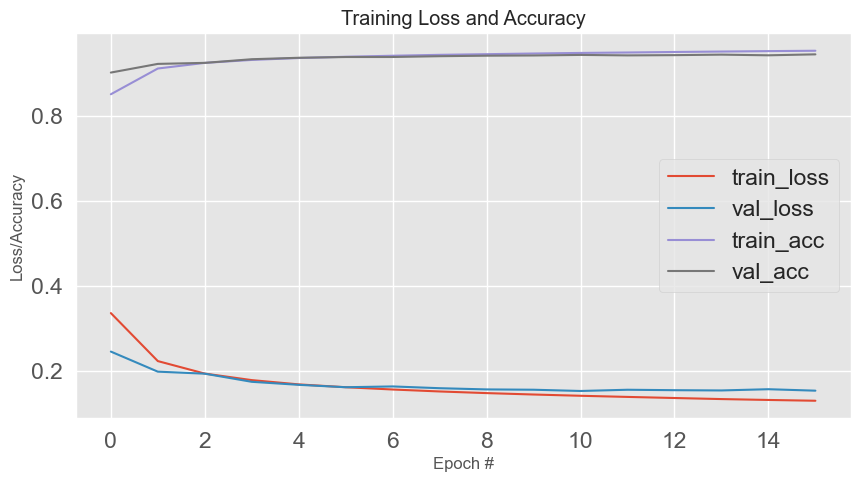

In [26]:
def generate_plot(H):
# plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    
H = model.fit(X_train, y_train, validation_split=0.2, epochs = 16)
generate_plot(H)

In [29]:
model.evaluate(X_test, y_test)

12500/12500 [==============================] - 121s 10ms/step - loss: 0.1549 - accuracy: 0.9440


[0.15485890209674835, 0.9439975023269653]

### Evaluation
The model performs exceedingly well, with an accuracy of around 94.4% on the test dataset.

In [35]:
y_prediction = model.predict(X_test)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, np.round(y_prediction), normalize= 'pred')

12500/12500 [==============================] - 90s 7ms/step


The confusion matrix for the dataset is shown below.

In [36]:
print(result)

[[0.948684   0.06059212]
 [0.051316   0.93940788]]
